<a href="https://colab.research.google.com/github/3x10e8/telluride-21/blob/neurodyn/Morris_Lecar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Morris-Lecar Model (1981)

The model is originally described in:

Morris, C., & Lecar, H. (1981). Voltage oscillations in the barnacle giant muscle fiber. Biophysical Journal, 35(1), 193–213. https://doi.org/10.1016/S0006-3495(81)84782-0

In [1]:
from numpy import tanh, cosh
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.integrate import odeint

In [10]:
# Constants from Figure 6 (p.205):
gL  =  2 # 0.5
VL = -50
VCa = 100
VK = -70
λMinf = 1
λNinf = .1

V1 = 0
V2 = 15
V3 = 10
V4 = 10

C  = 20 # 1.0 # membrane capacitance, in uF/cm^2
gCa = 4 #6 # 1.1 # maximum conducances, in mS/cm^2
gK = 8 #12

Vrest = -50 #mV

In [25]:
def Xinf(V, Va, Vb):
  return 0.5*(1 + tanh((V-Va)/Vb))

def λinf(λ, V, Va, Vb):
  return λ*cosh((V-Va)/(2*Vb))

def f_ML(y, t, params):
  V, M, N = y
  C, gL, gCa, gK, VL, VCa, VK, V1, V2, V3, V4, λMinf, λNinf, sig_gen = params

  I = sig_gen(t)
  IL = gL*(V-VL)
  ICa = gCa*M*(V-VCa)
  IK = gK*N*(V-VK)
  dVdt = (I -IL -ICa -IK)/C

  Minf = Xinf(V, V1, V2)
  λM = λinf(λMinf, V, V1, V2) 
  dMdt = λM*(Minf-M)

  Ninf = Xinf(V, V3, V4)
  λN = λNinf #λinf(λNinf, V, V3, V4)
  dNdt = λN*(Ninf-N)
  derivs = [dVdt, dMdt, dNdt]

  return derivs

Done in 0.32s


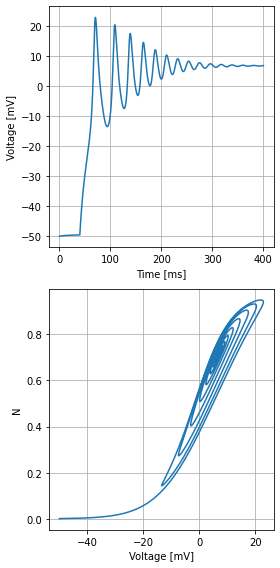

In [42]:
# Initial conditions
V0 = Vrest
M0 = 0
N0 = 0
y0 = [V0, M0, N0]

# Make time array for solution
tEnd_ms = 400.
dt = .1e-3
tt = np.arange(0.0, tEnd_ms, dt)

# Step current input
gain = 60
t0 = tEnd_ms*0.1
sig_gen = lambda t: gain*float(t >= t0)

# Collect model parameters
params = []
params.extend([C])
params.extend([gL, gCa, gK])
params.extend([VL, VCa, VK])
params.extend([V1, V2, V3, V4])
params.extend([λMinf, λNinf])
params.extend([sig_gen])

# Call the ODE solver
START_TIME = time.time()  # for timing execution
psoln = odeint(
    f_ML,
    y0,
    tt,
    args=(params,),
    # mxstep=5000000,
    # rtol=1e-15,
    # atol=1e-15,
    # full_output=1,
)

print("Done in {:.2f}s".format(time.time() - START_TIME))

fig, ax = plt.subplots(2, 1, figsize=(4,8))
ax[0].plot(tt, psoln[:, 0])
ax[0].grid()
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Voltage [mV]')

ax[1].plot(psoln[:, 0], psoln[:, 1])
ax[1].set_xlabel('Voltage [mV]')
ax[1].set_ylabel('N')
ax[1].grid()
plt.tight_layout()

# Teddy's Implementation

With equations from 
https://isn.ucsd.edu/courses/beng260/complab/week2/hw2_example.py

$$C_m \dot{V} = I_{ext} + I_{Ca} + I_{K} + I_{L}$$

where

$$I_{Ca} = g_{Ca} m_∞ (E_{Ca} - V)$$

$$I_K = g_K w (E_K - V)$$

$$I_L = g_L (E_L - V)$$




$$ \dot{m} = \frac{m - m_∞}{τ_m} $$  

But we assume $τ_m$ is small in the context of $\dot{V}$:

$$ \Rightarrow m ≈ m_∞ = \frac{1}{2} \left[ 1 + tanh\left( \frac{V - V_m}{dV_m} \right) \right] $$

$$ \dot{w} = \frac{w - w_∞}{τ_w} $$ 

Now we set $\frac{dV}{dt} = 0$ and $\frac{dw}{dt} = 0$



In [43]:
# Constants
C_m  =   1.0 # membrane capacitance, in uF/cm^2
g_Ca =   1.1 # maximum conducances, in mS/cm^2
g_K  =   2.0
g_L  =   0.5
E_Ca = 100.0 # Nernst reversal potentials, in mV
E_K  = -70.0
E_L  = -50.0

In [44]:
# Steady-state gating variables
def w_inf(V):
  return 0.5*(1 + tanh(V/30))

def m_inf(V):
  return 0.5*(1 + tanh((V+1)/15))

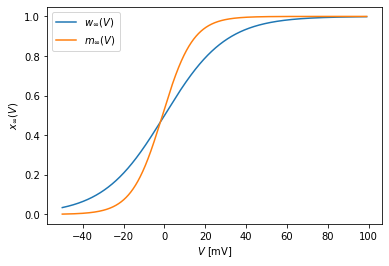

In [45]:
# Keep voltage between E_K and E_Ca
V_sweep = np.arange(E_K+20, E_Ca-1, .0001)

# Plot equilibrium values of gating variables
plt.plot(V_sweep, w_inf(V_sweep), label='$w_\infty(V)$')
plt.plot(V_sweep, m_inf(V_sweep), label='$m_\infty(V)$')
plt.xlabel('$V$ [mV]')
plt.ylabel('$x_\infty(V)$')
plt.legend()
plt.show()

In [46]:
# Generate nullclines for both state variables V and W
def plot_nc(V, I_ext):
  nc1 = I_ext - g_Ca*m_inf(V)*(V-E_Ca) - g_L*(V-E_L)
  nc1 /= g_K*(V-E_K)
  p = plt.plot(V, nc1, label='$\dot{V}$=0' + ' @ I = {:.2f}'.format(I_ext))
  plt.xlabel('V [mV]')
  plt.ylabel('W')

  nc2 = w_inf(V)
  plt.plot(V, nc2, label='$\dot{W}$=0' + ' @ I = {:.2f}'.format(I_ext))
  #plt.legend(loc='lower right')
  #plt.ylim(.2, .6)

  for intersection in V[np.abs(nc1 - nc2) <= 1e-6]:
    plt.axvline(x=intersection, c=p[0].get_color())

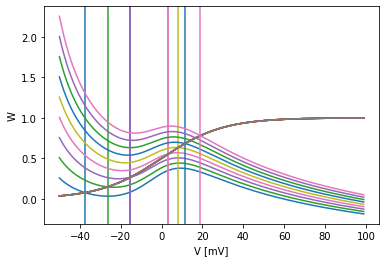

In [47]:
# Sweep current input and see how the nullclines shift
for I_ext in np.arange(10, 100, 10):
  plot_nc(V_sweep, I_ext)

# Vertical lines show where the nullclines intersect

In [ ]:
# Can we get two intersection points?

In [ ]:
# How do we determine whether the intersection is stable or unstable equlibrium?

# Further Reading
Stability analysis for reduced Hodgkin-Huxley models:

https://neurophysics.ucsd.edu/courses/physics_171/Reduced_Spike_Model.pdf

Bifurcation analysis of the AdEx neuron: 

http://www.scholarpedia.org/article/Adaptive_exponential_integrate-and-fire_model

Bard Ermentrout's INC chalk talk with SNICs:

https://youtu.be/XJYRTk5kRWE?t=2958 

